<a href="https://githubtocolab.com/Astolfo2332/Biosenales_el_regreso/blob/main/Proyecto_3_los_4GB.ipynb"
    target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" /></a>

# Proyecto 3

4 GB de audio no es nada

## Descarga de Kaggel

Aqui mete el json de kaggle

In [20]:
from google.colab import files

files.upload()


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
!mkdir - p ~/.kaggle
!cp kaggle.json ~/.kaggle/
'chmod 600 /root/.kaggle/kaggle.json'  # Para proteger la información


In [ ]:
!kaggle datasets download -d vbookshelf/respiratory-sound-database
! unzip respiratory-sound-database.zip


La mousque herramienta misteriosa

In [ ]:
!wget https://raw.githubusercontent.com/Astolfo2332/Biosenales_el_regreso/main/special_fun.py


# 1 El análisis

In [1]:
import matplotlib.pyplot as plt
import librosa
import pywt
import librosa.display
import scipy as sp
import numpy as np
from csv import reader as reader_csv;
import scipy.signal as signal
import spacy
import scipy.io as sio
import scipy.stats as stats
from sympy import symbols
import os
import sympy as sym
import pandas as pd
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import mannwhitneyu
from scipy.stats import levene
import pingouin as pg
import special_fun as s
from scipy.signal import kaiserord, lfilter, firwin, freqz


## 1.1 Carga

In [2]:
ruta_carpeta = './Data/audio_and_txt_files'
#Si es en colab
#ruta_carpeta = "/content/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files" 
lista_archivos = os.listdir(ruta_carpeta)
datos_sano,datos_crepitancia,datos_silbancia=s.el_discriminador(lista_archivos,ruta_carpeta)

In [3]:
print("Pacientes con ciclos sanos: ",len(datos_sano))
print("Pacientes con ciclos silbancias: ",len(datos_crepitancia))
print("Pacientes con ciclos crepitancias: ",len(datos_silbancia))

Pacientes con ciclos sanos:  714
Pacientes con ciclos silbancias:  499
Pacientes con ciclos crepitancias:  336


## Obtención de los audios

In [4]:
datos=s.sonido_probando123(lista_archivos,ruta_carpeta)

# Generación de espectros

In [5]:
sano_list,crackles_list,wheezes_list=s.el_discriminador_2(datos,datos_sano,datos_crepitancia,datos_silbancia,[2000,1000])

In [38]:

def el_promediador(datos_sano,datos_crepitancia,datos_silbancia):
    a=[datos_sano,datos_crepitancia,datos_silbancia]
    proms=[]
    for n in a:
        pro=[]
        for i in range(len(n)):
            pro.append(np.mean(n[i],axis=0))
        pro=np.array(pro)
        proms.append(np.mean(pro,axis=0))
    return proms

In [39]:
promedios=el_promediador(sano_list,crackles_list,wheezes_list)

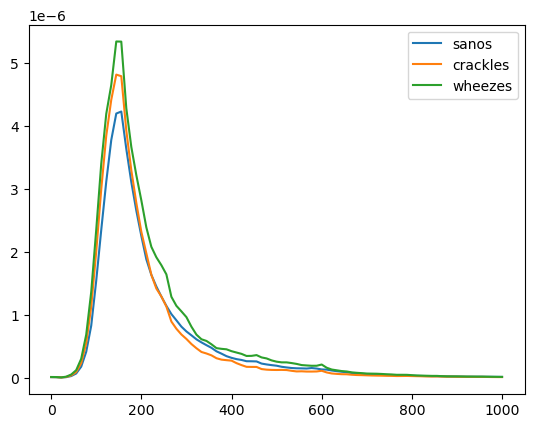

In [51]:
f=np.linspace(0,1000,len(promedios[0]))
for i in promedios:
    plt.plot(f,i)
plt.legend(["sanos","crackles","wheezes"])

In [61]:
df=pd.DataFrame( np.array(promedios))
df.to_csv("promedios.cvs",index=False)

In [ ]:
!wget https://raw.githubusercontent.com/Astolfo2332/Biosenales_el_regreso/main/special_fun.py

In [65]:
prom= np.loadtxt('promedios.cvs', delimiter=',')
prom=prom[1:]

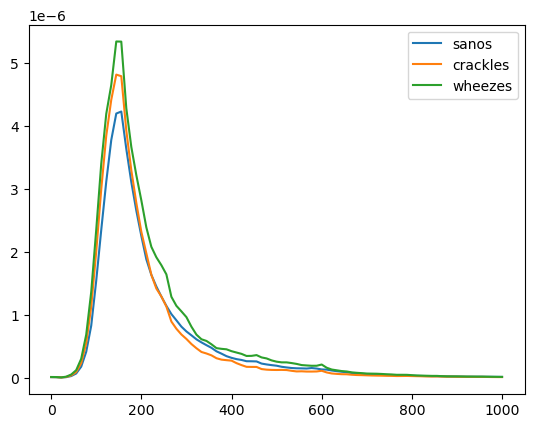

In [68]:
f=np.linspace(0,1000,len(prom[0]))
for i in prom:
    plt.plot(f,i)
plt.legend(["sanos","crackles","wheezes"])